In [71]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import copy
import scipy
from errorResult import MSE
from errorResult import RMSE
from errorResult import jdwucha
from errorResult import xdwucha
from errorResult import fanguiy
from errorResult import result
from errorResult import drawAll

def f(lmd,c):
    # return scipy.special.expit(-lmd*c)
    y = 1 / (1 + np.exp(-0.5*c))
    return y

def h(err):
    y = 1 / (2 * err + 1)
    return y

def errorLp(p,data_pre,data_real):
    dist = np.linalg.norm(data_pre-data_real,ord=p)/(data_pre.shape[0]*data_pre.shape[1])
    return dist
  
#%%
#返回初始化权重参数   NxN 
def initialize_parameters_he(npop,N):
    parameters = np.zeros((npop,N*N))
    for i in range(npop):
        parameter = np.random.uniform(-1,1,N*(N-1))
        #np.random.randn(N*(N-1)) * np.sqrt(2.0 / (N*(N-1)))
        lmd = np.random.uniform(0,1,N)
        #lmd = np.array([1]*N)
        parameters[i] = parameter.tolist()+lmd.tolist()
    return parameters
    
def rshape(X,N):
    temp = copy.copy(X)
    e = np.zeros((N,N))
    param = temp[:-N]   
    lmd = temp[-N:]
    num = 0
    for i in range(N):
        for j in range(N):
            if i is not j:
                e[i,j] = param[num]
                num = num + 1
    return e,lmd
    
#jaya学习算法训练FCM参数
def jayaTrain(c_data,c_real,time,N,npop=4):
    X = initialize_parameters_he(npop,N)
    print(rshape(X[1,:],N))
#    for n in range(npop):
#        for i in range(N*N):
#            X[n,i] = min(X[:,i]) + np.random.random()*(max(X[:,i])-min(X[:,i]))
    fitness = np.zeros(npop)
    error = np.zeros(npop)
    worst= 0
    best = 0
    error_time = []
    c_pre = np.zeros((c_real.shape[0],c_real.shape[1]))
    for num in range(500):
        for n in range(npop):
            e,lmd = rshape(X[n,:],N)
            #print("c_data.shape: %s" % c_data.shape)
            c_pre = fcm(e,lmd,c_data,c_real,time)
            #print("c_pre, c_real: %s ,%s" % c_pre.shape, c_real.shape)
            fitness[n] = h(errorLp(2,c_pre,c_real)) 
            error[n] = errorLp(2,c_pre,c_real)
        worst = fitness.tolist().index(min(fitness))
        best = fitness.tolist().index(max(fitness))
        print(worst,best,fitness)
    
        Xx = np.zeros((npop,N*N))
        for n in range(npop):
            rand1 = np.random.uniform(0,1)
            rand2 = np.random.uniform(0,1)
            Xx[n,:] = X[n,:] + (X[best,:]-np.abs(X[n,:]))*rand1-(X[worst,:]-np.abs(X[n,:]))*rand2
            '''
            for i in range(N*N):
                if Xx[n,i] < min(Xx[:,i]):
                    Xx[n,i] = min(Xx[:,i])
                if Xx[n,i] > max(Xx[:,i]):
                    Xx[n,i] = max(Xx[:,i])
            '''
            e,lmd = rshape(Xx[n,:],N)
            c_pre = fcm(e,lmd,c_data,c_real,time)
            error2 = errorLp(2,c_pre,c_real)
            if error2 <= error[n]:
                X[n,:] = Xx[n,:]              
        error_time.append(error[best])
    e,lmd = rshape(X[best,:],N)
    return e,lmd,error_time

#模糊认知图递推过程      
def fcm(e,lmd,data_front,data,time):
    '''
    c_len = len(data)
    data_pre = np.zeros((time+1,c_len))
    data_pre[0] = data_front
    
    for t in range(0,time):
        for i in range(c_len):
            for j in range(c_len):
                if i is not j :
                    data_pre[t+1,i] += e[j,i]*data[t,j]
            data_pre[t+1,i] += data[t,i]
            data_pre[t+1,i] = f(lmd[i],data[t+1,i])
    
    '''
    c_len = len(data_front)
    data_pre = np.zeros((time,c_len))
    data_pre[0] = np.dot(data_front,e)
    for i in range(c_len):
        data_pre[0,i] = f(lmd[i],data_pre[0,i])
    for t in range(0,time-1):
        data_pre[t+1] = np.dot(data[t],e)
        for i in range(c_len):
            data_pre[t+1,i] = f(lmd[i],data_pre[t+1,i])
    return data_pre

#模糊认知图递推过程训练用   
def fcmm(e,lmd,data_front):
    c_len = len(data_front)
    data_pre = np.dot(data_front,e)
    for i in range(c_len):
        data_pre[i] = f(lmd[i],data_pre[i])
    
    return data_pre

In [72]:
#%% 
if __name__ == "__main__":
    data = pd.read_csv('dataProcess.csv',index_col = 0)
    data = np.array(data)
    train_time = 504               #设置滑动窗口
    start = 100
    hour = 100   
    concept = data.shape[1]
    
    #data_train = data[240:600,:]   #20天做训练
    data_test = data[start+train_time:start+train_time+hour,:]     #3天做测试
    data_pre = np.zeros((data_test.shape[0],data_test.shape[1]))
    data_train = data[start:train_time+start,:]
    
    e,lmd,error_time = jayaTrain(data[start-1,:],data_train,train_time,concept,npop = 8)
    
    for i in range(0,hour):
        #data_train = data[i+start:i+train_time+start,:]
        data_real = data[i+start+train_time-1,:]
        #e,lmd,error_time = jayaTrain(data[i+start-1,:],data_train,train_time,concept,npop = 8)
        data_pre[i] = fcmm(e,lmd,data_real)   

(array([[ 0.        ,  0.98532336, -0.07217869, -0.76493383, -0.31344328,
         0.47604805],
       [-0.72214226,  0.        , -0.46599055, -0.2645304 , -0.51769059,
        -0.46158084],
       [-0.5167853 ,  0.27335912,  0.        , -0.35586331,  0.67527623,
         0.19291804],
       [ 0.09240918,  0.06080274, -0.49857738,  0.        ,  0.56153651,
        -0.511394  ],
       [-0.81540246, -0.60247222, -0.00403917,  0.73885885,  0.        ,
         0.89232339],
       [-0.66605081, -0.85379151, -0.93344421, -0.71579808, -0.02433681,
         0.        ]]), array([0.028814  , 0.57081272, 0.14901409, 0.62006866, 0.82083069,
       0.41741139]))
0 2 [0.98668789 0.98730617 0.98766165 0.98709014 0.98694994 0.98719205
 0.98716963 0.98712321]
0 2 [0.98668789 0.98763652 0.98814294 0.98808706 0.98694994 0.98719205
 0.98766036 0.98783737]
4 6 [0.9882967  0.98819461 0.98814294 0.98808706 0.98694994 0.98757499
 0.9888574  0.98783737]
5 7 [0.98952357 0.98819461 0.98825056 0.98979958 0.988

0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 0.9953726
 0.99539362 0.99532823]
0 2 [0.99532299 0.99542407 0.99544295 0.99541542 0.99538869 

7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0.99548237 0.99551191
 0.99558342 0.99543803]
7 6 [0.99547436 0.99556473 0.99544295 0.99556123 0

5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0.99560295 0.99559562
 0.99564162 0.99569198]
5 0 [0.99569668 0.99560307 0.99567429 0.99567126 0

6 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99564162 0.99569198]
6 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99564162 0.99569198]
6 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99564162 0.99569198]
6 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99564162 0.99569198]
6 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99564162 0.99569198]
6 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99564162 0.99569198]
6 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99564162 0.99569198]
7 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99570533 0.99569198]
7 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99570533 0.99569198]
7 4 [0.99569866 0.99571469 0.99575202 0.99569712 0.99576192 0.99576069
 0.99570533 0.99569198]
7 4 [0.99569866 0.99571469 0.99575202 0.99569712 0

1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0.99576806 0.99576069
 0.99577504 0.99577346]
1 6 [0.99572241 0.99571469 0.99575202 0.99573125 0

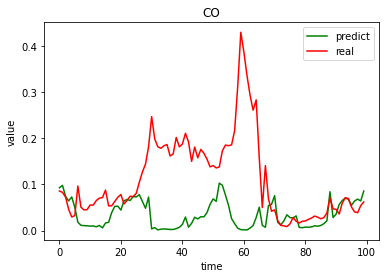

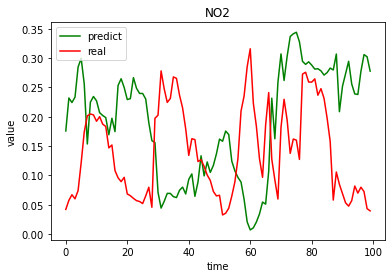

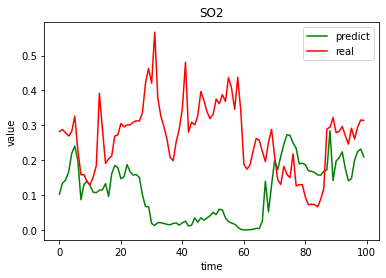

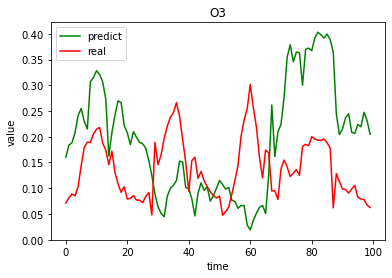

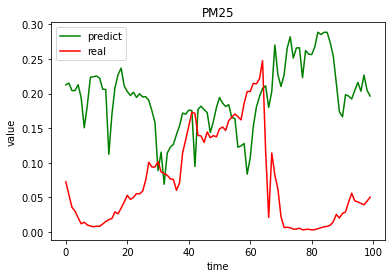

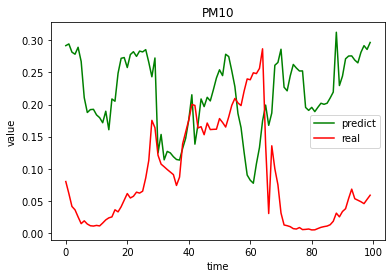

绝对误差：[0.08196616 0.12250978 0.17881378 0.11777271 0.13432161 0.15051313]
相对误差：[ 0.64237032  1.3856017   0.65206096  0.95881886 11.95874767  7.85441709]
欧式距离：0.03937545874525136
MSE：[0.01528455 0.02065043 0.0467473  0.01813175 0.02493182 0.02929683]
RMSE:[0.12363068 0.14370258 0.21621124 0.13465419 0.15789814 0.17116316]


In [73]:
drawAll(data_pre,data_test)
result(data_pre,data_test,'jaya_opt')

In [74]:
print(e)

[[  0.         -19.32783083 -21.64740283 -11.58224611  -0.68210068
   -0.76756827]
 [-18.92166991   0.           0.18213558  -0.20325986   1.41787402
   -2.28955991]
 [ -8.33794428  -1.89827013   0.          -6.04937695  -7.46177785
   -2.59612673]
 [-21.02449477  -6.54849044 -13.64395841   0.          -8.33066145
  -10.26067488]
 [  2.25023743   0.7123151   -7.68011397  -2.8160285    0.
   -1.73749839]
 [  0.41731395   2.58713756  -4.45919046  -0.93975327   1.31660142
    0.        ]]
